In [1]:
import scanpy as sc
sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=250, format='pdf')
import numpy as np
import pandas as pd
from scipy import io
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns
%matplotlib inline
from pathlib import Path


In [2]:
adata = sc.read_h5ad(Path(PATH_FILE)/'exp1_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 214059 × 4347
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'lib', 'original_name', 'condition\xa0_x', 'condition\xa0_y', 'condition_name_full', 'cell_line_1', 'cell_line_2', 'batch', 'medium', 'morphogen', 'morphogen_full', 'Batch_Medium', 'medium_morphogen', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_line_1_colors', 'hvg', 'leiden', 'leiden_colors', 'lib_colors', 'log1p', 'medium_colors', 'morphogen_colors', 'morphogen_full_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Cell line pools

In [19]:
adata.obs.cell_line_1

0           H1 plate 1
1           H1 plate 1
2           H1 plate 1
3           H1 plate 1
4           H1 plate 1
              ...     
214054    WIBJ plate 4
214055    WIBJ plate 4
214056    WIBJ plate 4
214057    WIBJ plate 4
214058    WIBJ plate 4
Name: cell_line_1, Length: 214059, dtype: category
Categories (8, object): ['H1 plate 1', 'H1 plate 2', 'H1 plate 3', 'H1 plate 4', 'WIBJ plate 1', 'WIBJ plate 2', 'WIBJ plate 3', 'WIBJ plate 4']

In [9]:
adata.obs['cell_line_pool']  = adata.obs['cell_line_1'].str.split(' ').str[0]

In [10]:
adata.obs.loc[adata.obs['cell_line_pool']=='H1', 'cell_line_pool'] = 'ESC'

adata.obs.loc[adata.obs['cell_line_pool']=='WIBJ', 'cell_line_pool'] = 'iPSC'

In [11]:
adata.obs['cell_line_pool'].value_counts()

cell_line_pool
ESC     114921
iPSC     99138
Name: count, dtype: int64

# Add demultiplexing results

In [15]:


adata.obs.index = adata.obs.original_name.copy()

adata.obs.index.name = None

In [16]:
df = pd.read_csv(Path(PATH_FILE)/'vireo_WIBJ_nodoub/donor_ids.tsv',
                 sep='\t')
df.head()

cell    donor_id  prob_max  prob_doublet  n_vars best_singlet  \
0  07_01_04__s1         WTC     1.000           0.0      14          WTC   
1  07_01_04__s2  unassigned     0.992           0.0       7          WTC   
2  07_01_06__s3         WTC     0.999           0.0      16          WTC   
3  07_01_07__s4         WTC     1.000           0.0      17          WTC   
4  07_01_08__s2       WIBJ2     0.996           0.0      12        WIBJ2   

  best_doublet  doublet_logLikRatio  
0    WIBJ2,WTC                  0.0  
1    WIBJ2,WTC                  0.0  
2    WIBJ2,WTC                  0.0  
3    WIBJ2,WTC                  0.0  
4    WIBJ2,WTC                  0.0

In [17]:
adata.obs = pd.merge(adata.obs, df[['cell', 'prob_max', 'best_singlet']], left_on = 'original_name', right_on = 'cell', how='left')

In [18]:
adata.obs = adata.obs.rename(columns = {'prob_max':'iPSC_prob_max', 	'best_singlet':'iPSC_best_singlet'})
del adata.obs['cell']
adata.obs.index = adata.obs.original_name.copy()

adata.obs.index.name = None

In [19]:
adata.obs.head()

n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
01_01_21__s1               2600          4652               68       1.461737   
01_01_23__s1               1617          2499               54       2.160864   
01_01_26__s1               5209         15899              187       1.176175   
01_01_31__s1               3877          9904              149       1.504443   
01_01_38__s1               4375          9521              165       1.733011   

             sample lib original_name  condition _x  condition _y  \
01_01_21__s1     01  s1  01_01_21__s1             1             1   
01_01_23__s1     01  s1  01_01_23__s1             1             1   
01_01_26__s1     01  s1  01_01_26__s1             1             1   
01_01_31__s1     01  s1  01_01_31__s1             1             1   
01_01_38__s1     01  s1  01_01_38__s1             1             1   

             condition_name_full  ... Batch_Medium medium_morphogen leiden  \
01_01_21__s1         B1_NIM_Ctrl  ...       B1_NIM         Ctrl_NIM     28   
01_01_23__s1         B1_NIM_Ctrl  ...       B1_NIM         Ctrl_NIM      1   
01_01_26__s1         B1_NIM_Ctrl  ...       B1_NIM         Ctrl_NIM      5   
01_01_31__s1         B1_NIM_Ctrl  ...       B1_NIM         Ctrl_NIM      5   
01_01_38__s1         B1_NIM_Ctrl  ...       B1_NIM         Ctrl_NIM     29   

             cell_class_v1  region_v1        fullname_v1 cell_line_pool  \
01_01_21__s1       NPC-G2M     Retina     NPC-G2M_Retina            ESC   
01_01_23__s1           NPC  Forebrain      NPC_Forebrain            ESC   
01_01_26__s1       NPC-G2M  Forebrain  NPC-G2M_Forebrain            ESC   
01_01_31__s1       NPC-G2M  Forebrain  NPC-G2M_Forebrain            ESC   
01_01_38__s1       NPC-G2M     Retina     NPC-G2M_Retina            ESC   

             line_medium iPSC_prob_max iPSC_best_singlet  
01_01_21__s1     ESC_NIM           NaN               NaN  
01_01_23__s1     ESC_NIM           NaN               NaN  
01_01_26__s1     ESC_NIM           NaN               NaN  
01_01_31__s1     ESC_NIM           NaN               NaN  
01_01_38__s1     ESC_NIM           NaN               NaN  

[5 rows x 26 columns]

In [20]:
df = pd.read_csv(Path(PATH_FILE)/'vireo_H9_nodoub/donor_ids.tsv',
                 sep='\t')
df.head()

cell donor_id  prob_max  prob_doublet  n_vars best_singlet  \
0  01_01_01__s2       H9     1.000           0.0      59           H9   
1  01_01_01__s4       H9     1.000           0.0      54           H9   
2  01_01_05__s3       H9     1.000           0.0      43           H9   
3  01_01_05__s4       H9     0.999           0.0      55           H9   
4  01_01_13__s4       H1     1.000           0.0      49           H1   

  best_doublet  doublet_logLikRatio  
0        H1,H9                  0.0  
1        H1,H9                  0.0  
2        H1,H9                  0.0  
3        H1,H9                  0.0  
4        H1,H9                  0.0

In [21]:
adata.obs = pd.merge(adata.obs, df[['cell', 'prob_max', 'best_singlet']], left_on = 'original_name', right_on = 'cell', how='left')

adata.obs = adata.obs.rename(columns = {'prob_max':'ESC_prob_max', 	'best_singlet':'ESC_best_singlet'})
del adata.obs['cell']
adata.obs.index = adata.obs.original_name.copy()

adata.obs.index.name = None

In [22]:
def name_demuxlet(pool_col, ipsc_prob, ipsc_line, esc_prob, esc_line):
    if pool_col =='ESC':
        if esc_prob>=0.9:
            return esc_line
        else:
            return 'ESC'
    else:
        if ipsc_prob>=0.9:
            return ipsc_line
        else:
            return 'iPSC'
            

In [23]:
adata.obs['cell_line'] = adata.obs.apply(
        lambda x: name_demuxlet(x.cell_line_pool, x.iPSC_prob_max,x.iPSC_best_singlet,x.ESC_prob_max,x.ESC_best_singlet),axis=1)

In [24]:
adata.obs['cell_line'].value_counts()

cell_line
H1       59179
H9       44943
WTC      40744
WIBJ2    33275
iPSC     25119
ESC      10799
Name: count, dtype: int64

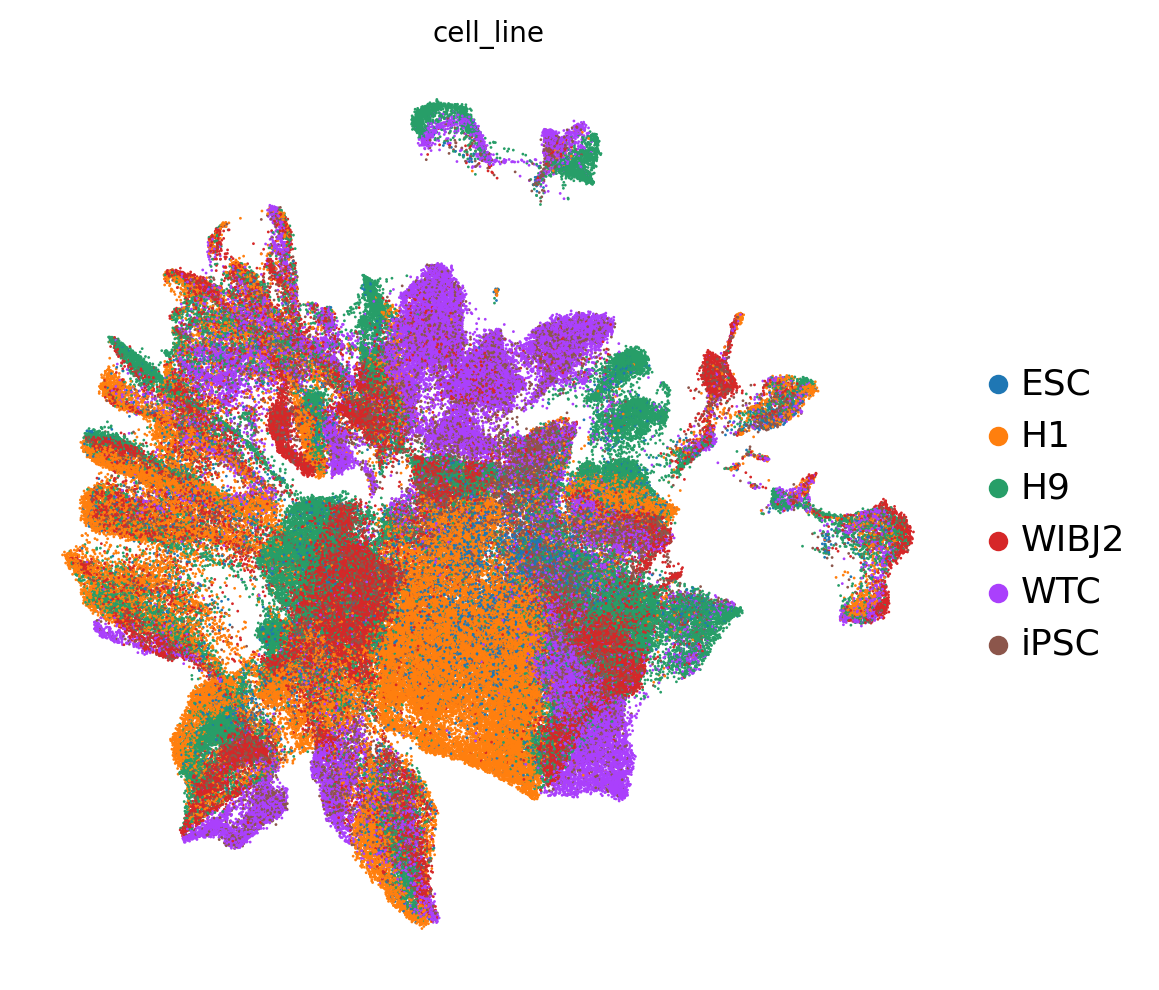

In [25]:
sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=350, format='.pdf')
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color=['cell_line'], 
               frameon=False,legend_loc='right margin', legend_fontsize=13,s=4, )
               #save='_v5_annotation_reg_legend.pdf',
             # palette = region_type_dict)

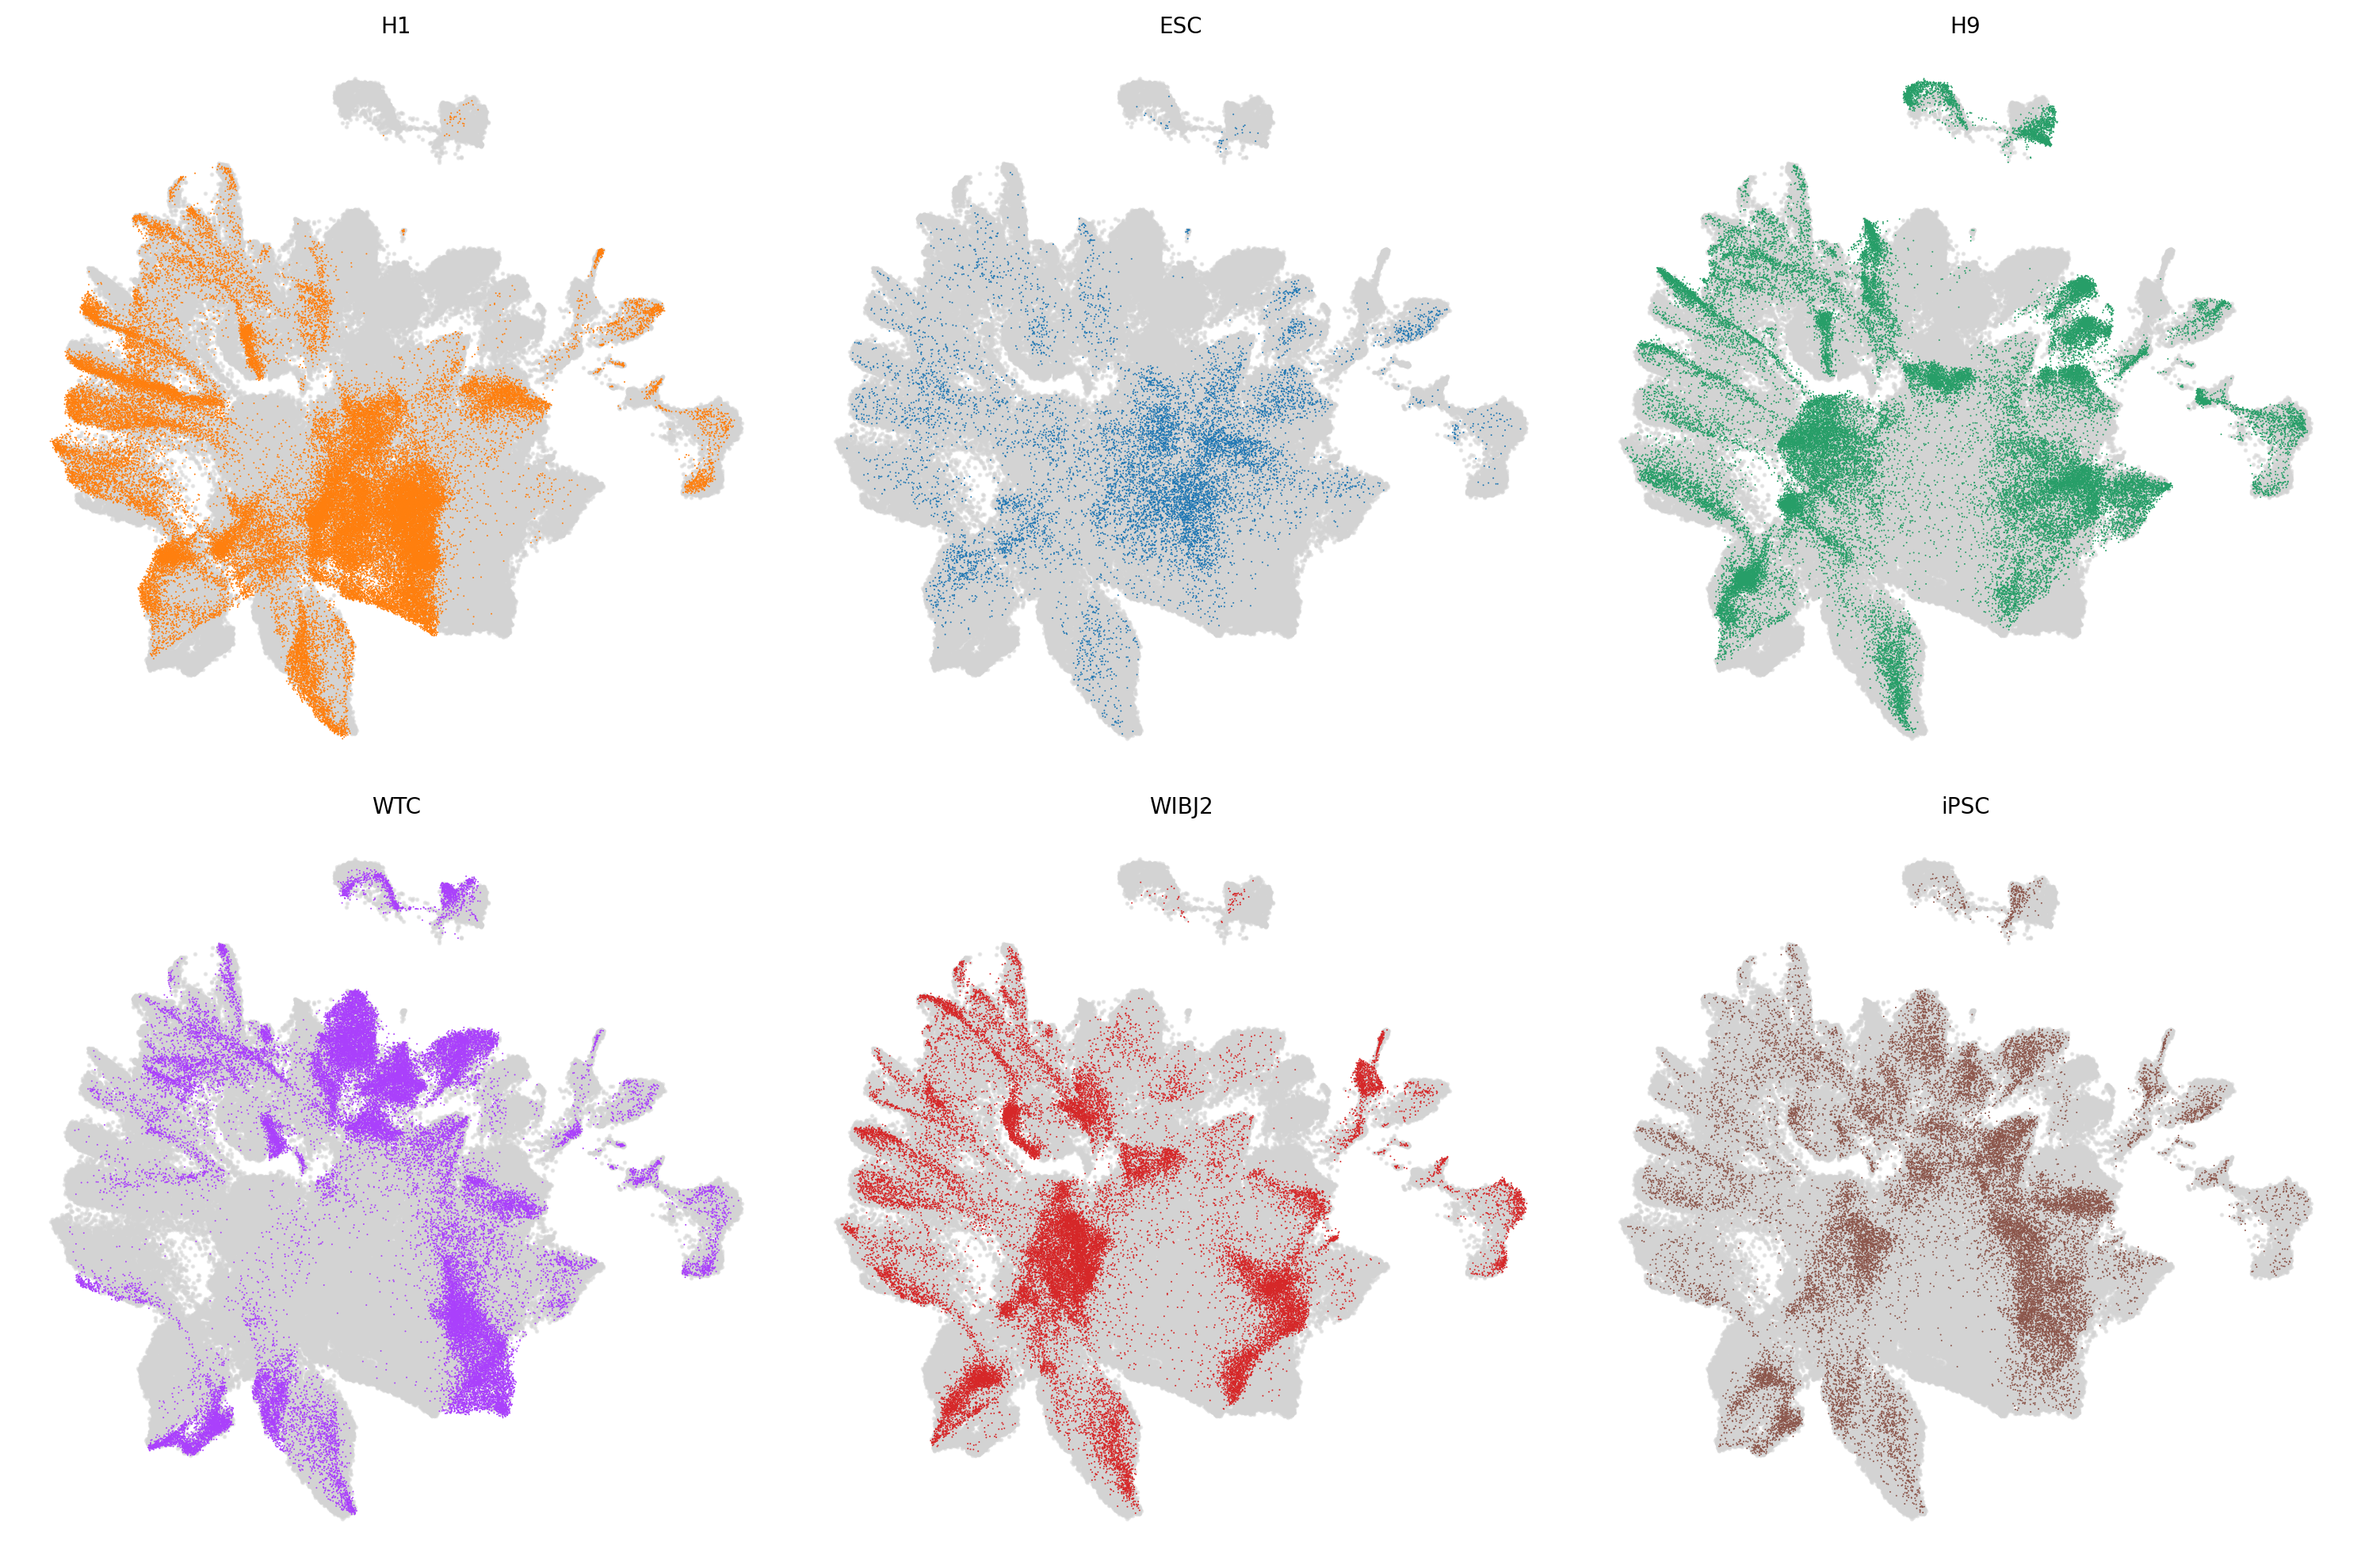

In [32]:
plot_separately(adata, 'cell_line')

### Check Y gene expression

In [58]:
Y_genes_2 = ['SRY', 'ZFY', 'RPS4Y1', 'AMELY', 'TBL1Y', 'PCDH11Y', 'TGIF2LY', 'TSPY1', 'TSPY2', 'AZF', 'USP9Y', 'DDX3Y','UTY', 'TB4Y',
              'RPS4Y2', 'EIF1AY', 'KDM5D', 'XKRY', 'HSFY1', 'PRY', 'RBMY1A1', 'PRY2', 'DAZ1', 'DAZ2', 'DAZ3', 'DAZ4', 'CDY1', 'CDY2', 'VCY1', 'VCY2']

In [59]:
## for known
gene_list = list(set(adata.raw.var_names).intersection(Y_genes_2))

gene_exp = pd.DataFrame(adata[adata.obs.cell_line.isin(['WTC', 'H9', 'H1', 'WIBJ2'])].raw[:,gene_list].X.A, columns=gene_list)



gene_exp['total'] = gene_exp.sum(axis=1)

# Add the 'Line' column from adata.obs['Consensus_line']
gene_exp['Line'] = adata[adata.obs.cell_line.isin(['WTC', 'H9', 'H1', 'WIBJ2'])].obs['cell_line'].values




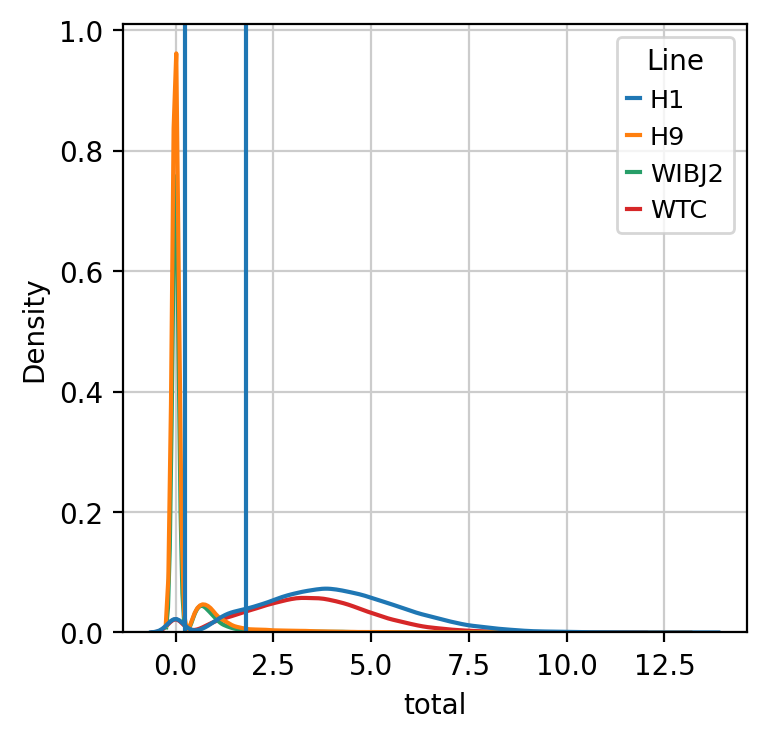

In [63]:
sns.kdeplot(data=gene_exp, x="total", hue="Line")
plt.axvline(x=1.8)
plt.axvline(x=0.25)

(5340, 15)
(10799, 15)


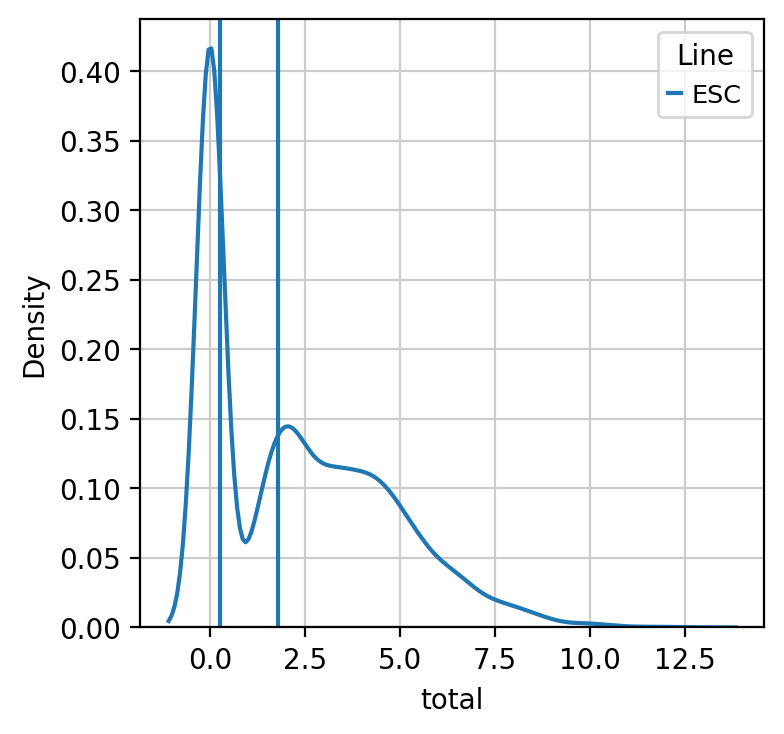

In [64]:
## for unknown

gene_exp = pd.DataFrame(adata[adata.obs.cell_line.isin(['ESC'])].raw[:,gene_list].X.A, columns=gene_list)



gene_exp['total'] = gene_exp.sum(axis=1)

# Add the 'Line' column from adata.obs['Consensus_line']
gene_exp['Line'] = adata[adata.obs.cell_line.isin(['ESC'])].obs['cell_line'].values
gene_exp['original_name'] = adata[adata.obs.cell_line.isin(['ESC'])].obs['original_name'].values
sns.kdeplot(data=gene_exp, x="total", hue="Line")
plt.axvline(x=1.8)
plt.axvline(x=0.25)
print(gene_exp[gene_exp.total>2].shape)
print(gene_exp.shape)

In [65]:
adata.obs.loc[gene_exp[gene_exp.total>1.8].original_name.values.tolist(), 'cell_line'] = 'H1'
adata.obs.loc[gene_exp[gene_exp.total<0.25].original_name.values.tolist(), 'cell_line'] = 'H9'


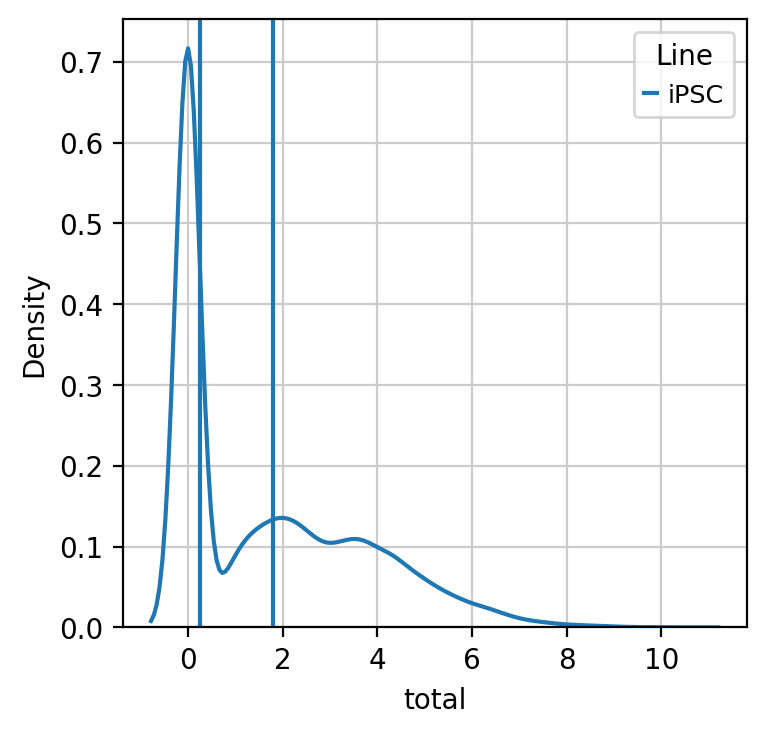

In [71]:
gene_exp = pd.DataFrame(adata[adata.obs.cell_line.isin(['iPSC'])].raw[:,gene_list].X.A, columns=gene_list)



gene_exp['total'] = gene_exp.sum(axis=1)

# Add the 'Line' column from adata.obs['Consensus_line']
gene_exp['Line'] = adata[adata.obs.cell_line.isin(['iPSC'])].obs['cell_line'].values
gene_exp['original_name'] = adata[adata.obs.cell_line.isin(['iPSC'])].obs['original_name'].values
sns.kdeplot(data=gene_exp, x="total", hue="Line")
plt.axvline(x=1.8)
plt.axvline(x=0.25)

In [72]:
adata.obs.loc[gene_exp[gene_exp.total>1.8].original_name.values.tolist(), 'cell_line'] = 'WTC'
adata.obs.loc[gene_exp[gene_exp.total<0.25].original_name.values.tolist(), 'cell_line'] = 'WIBJ2'


In [73]:
adata.obs.cell_line.value_counts()

cell_line
H1       64860
WTC      51051
H9       49040
WIBJ2    44951
iPSC      3136
ESC       1021
Name: count, dtype: int64

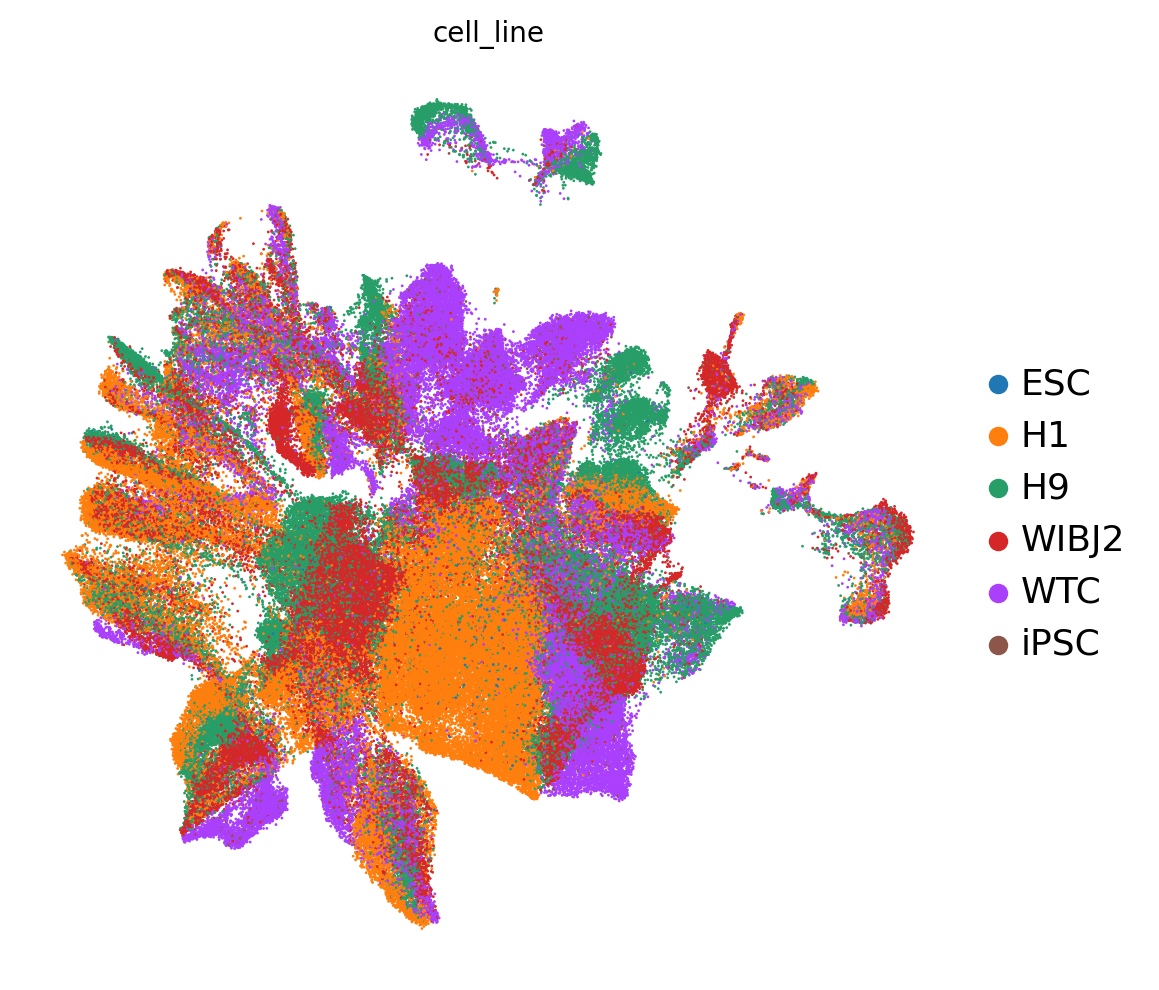

In [74]:
sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=350, format='.pdf')
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color=['cell_line'], 
               frameon=False,legend_loc='right margin', legend_fontsize=13,s=4, )
               #save='_v5_annotation_reg_legend.pdf',
             # palette = region_type_dict)

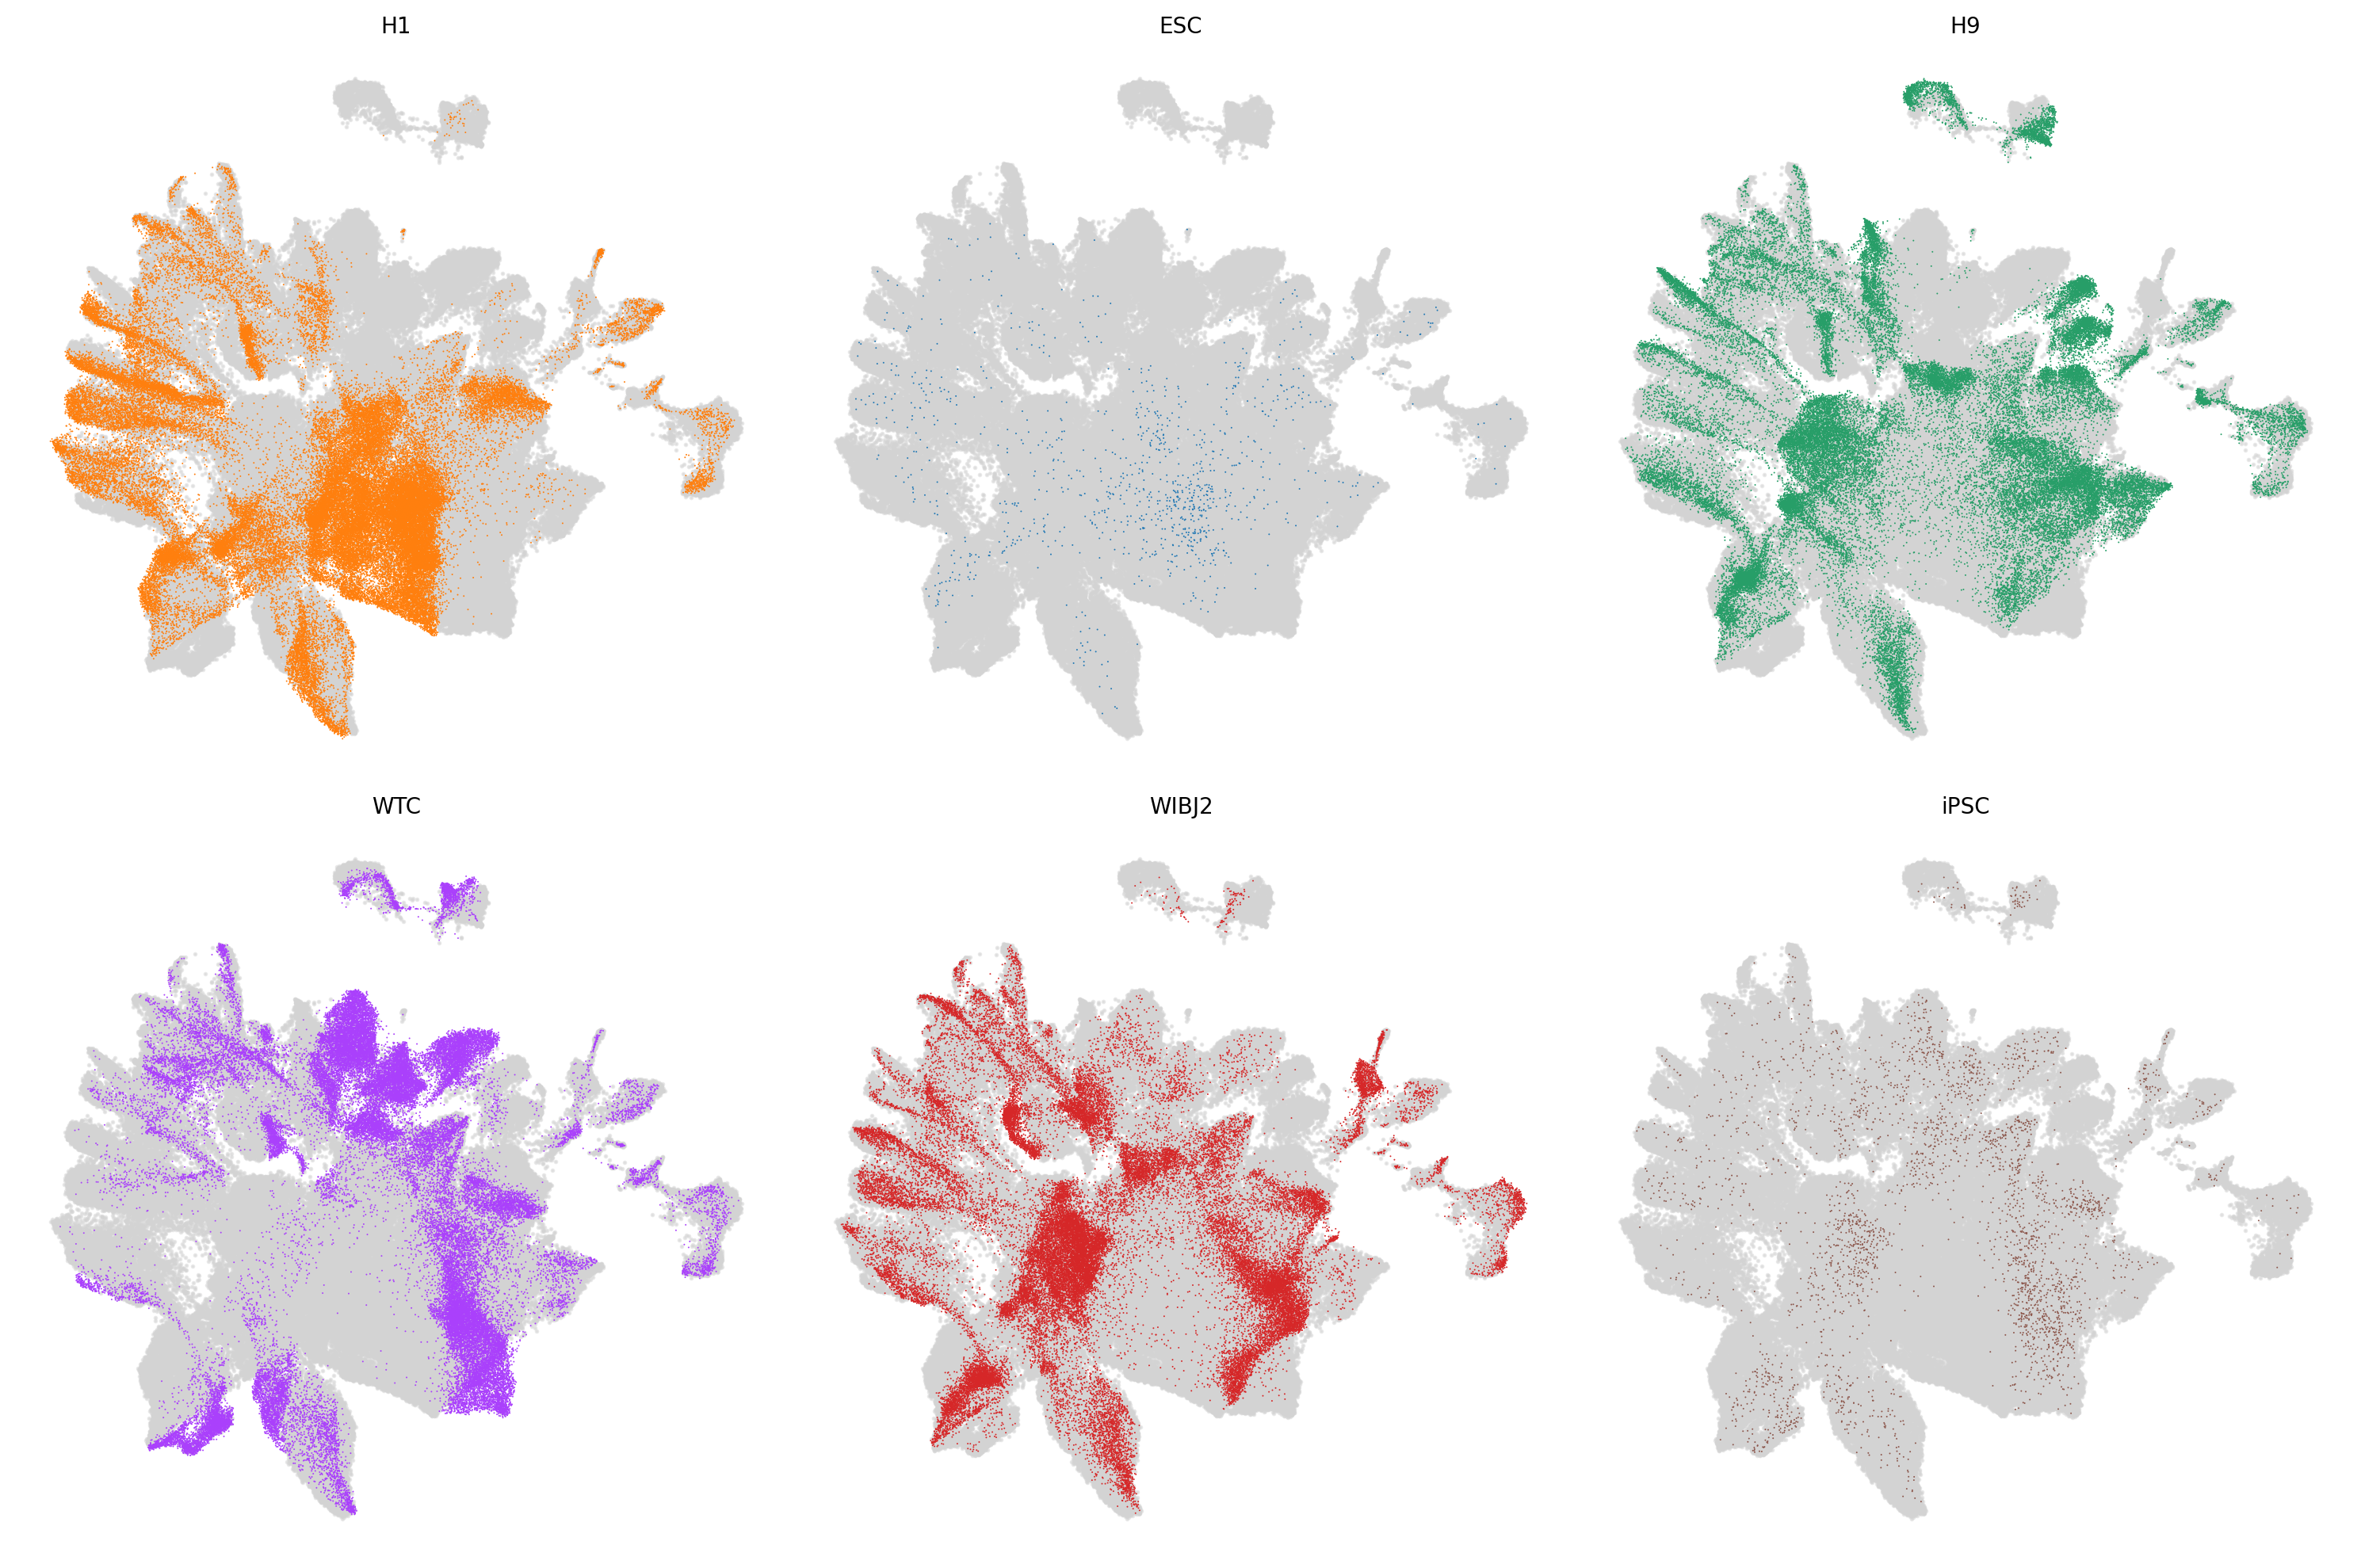

In [75]:
plot_separately(adata, 'cell_line')

In [77]:
adata.write(Path(PATH_FILE)/'exp1_processed_2.h5ad')